<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/presion_calibracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Process the uploaded CSV "/mnt/data/Pre.csv" as requested.
import pandas as pd
import re
from pathlib import Path
from datetime import timedelta
import numpy as np

inp_path = Path("/content/Pre.csv")
out_clean = Path("/content/Pre_clean.csv")
out_segments = Path("/content/Pre_segments.csv")

# 1) Load CSV (robust to comma/semicolon/tab)
try:
    df = pd.read_csv(inp_path, sep=None, engine="python")
except Exception as e:
    # fallback: try comma
    df = pd.read_csv(inp_path)

# 2) Detect columns
# Try a few variants for the cm column
cm_raw_col = None
for cand in ["cm H20", "cm H2O", "cmH2O", "cmH20", "cm", "cmH_20"]:
    if cand in df.columns:
        cm_raw_col = cand
        break
if cm_raw_col is None:
    raise ValueError(f"No encuentro la columna de cm en {list(df.columns)}")

# Lectura column
lec_col = None
for cand in ["Lectura esp32", "lectura esp32", "Lectura", "Raw", "Lectura_esp32"]:
    if cand in df.columns:
        lec_col = cand
        break
if lec_col is None:
    raise ValueError(f"No encuentro la columna 'Lectura esp32' en {list(df.columns)}")

# Preserve the raw cm column before forward-fill
df["cm_raw"] = df[cm_raw_col]

# 3) Forward-fill cm values
df["cm"] = df["cm_raw"].ffill()

# Coerce cm to numeric if possible
df["cm"] = pd.to_numeric(df["cm"], errors="coerce")

# 4) Parse "Lectura esp32" with regex
PAT = re.compile(
    r"""^\s*
        (?P<hora>\d{2}:\d{2}:\d{2}\.\d{3})      # 19:09:46.754
        \s*->\s*RAW\s+signed:\s*(?P<signed>-?\d+)
        \s*\|\s*RAW\s+unsigned:\s*(?P<unsigned>\d+)
        \s*\(bin\s*(?P<bin>[01\s]+)\)
        """, re.X
)

def parse_row(text):
    if pd.isna(text):
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA],
                         index=["hora","RAW_signed","RAW_unsigned","bin"])
    m = PAT.search(str(text))
    if not m:
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA],
                         index=["hora","RAW_signed","RAW_unsigned","bin"])
    return pd.Series([
        m.group("hora"),
        int(m.group("signed")),
        int(m.group("unsigned")),
        m.group("bin").replace(" ", "")
    ], index=["hora","RAW_signed","RAW_unsigned","bin"])

parsed = df[lec_col].apply(parse_row)
df = pd.concat([df, parsed], axis=1)

# Drop rows that didn't parse
df = df.dropna(subset=["RAW_signed","RAW_unsigned"]).copy()

# 5) Convert hour to datetime (no date)
df["hora_dt"] = pd.to_datetime(df["hora"], format="%H:%M:%S.%f", errors="coerce")

# 6) Build segments: a new segment starts each time the original cm_raw cell is non-null
is_new_block = df["cm_raw"].notna()
df["segment_id"] = is_new_block.cumsum()

# Also create a per-cm running index (e.g., 3.4#1, 3.4#2, ...)
df["cm_run"] = np.where(is_new_block, 1, 0)
df["cm_run"] = df.groupby("cm")["cm_run"].cumsum()

# 7) Compute per-segment stats including standard deviation
g = df.groupby("segment_id", dropna=False)
seg_stats = g.agg(
    cm=("cm","first"),
    cm_run=("cm_run","first"),
    n=("segment_id","size"),
    mean_signed=("RAW_signed","mean"),
    std_signed=("RAW_signed", lambda s: float(np.std(s, ddof=1)) if len(s)>1 else float("nan")), # Calculate std dev
    mean_unsigned=("RAW_unsigned","mean"),
    std_unsigned=("RAW_unsigned", lambda s: float(np.std(s, ddof=1)) if len(s)>1 else float("nan")), # Calculate std dev
    start_time=("hora_dt","min"),
    end_time=("hora_dt","max")
).reset_index()
seg_stats["duration_s"] = (seg_stats["end_time"] - seg_stats["start_time"]).dt.total_seconds()

# Add pressure conversions
CMH2O_TO_MMHG = 0.735559240
seg_stats["cmHg"] = seg_stats["cm"] / 13.5951
seg_stats["mmHg"] = seg_stats["cm"] * CMH2O_TO_MMHG
seg_stats["dP_mmHg"] = 0.05 * CMH2O_TO_MMHG # Assuming 0.05 cm uncertainty


# 8) Attach means to each row
df = df.merge(seg_stats[["segment_id","mean_signed","mean_unsigned","n"]], on="segment_id", how="left")
df.rename(columns={
    "mean_signed":"seg_mean_signed",
    "mean_unsigned":"seg_mean_unsigned",
    "n":"seg_n"
}, inplace=True)

# 9) Select and order output columns
cols_out = [
    "cm","cm_run","segment_id","seg_n",
    "hora","RAW_signed","RAW_unsigned","bin",
    "seg_mean_signed","seg_mean_unsigned"
]
# keep originals for convenience at the end
others = [c for c in df.columns if c not in cols_out]
df_out = df[cols_out + others]

# 10) Save outputs - Save seg_stats with new columns
df_out.to_csv(out_clean, index=False)
seg_stats.to_csv(out_segments, index=False)

# Preview to user
# from caas_jupyter_tools import display_dataframe_to_user
# display_dataframe_to_user("Vista previa - Datos limpios (primeras 200 filas)", df_out.head(200))
# display_dataframe_to_user("Resumen por segmentos", seg_stats)

out_clean, out_segments, df_out.shape, seg_stats.shape

(PosixPath('/content/Pre_clean.csv'),
 PosixPath('/content/Pre_segments.csv'),
 (1602, 14),
 (162, 14))

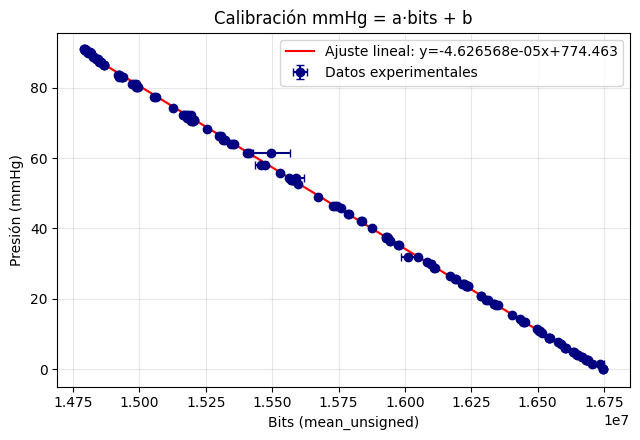

,Parámetro,Valor
0,Pendiente a,-4.626568e-05
1,Intercepto b,7.744630e+02
2,σ(a),6.465164e-08
3,σ(b),1.015831e+00
4,R²,9.996935e-01
5,N,1.590000e+02



Ecuación del ajuste:
mmHg = (-4.626568e-05 ± 6.465164e-08)·bits + (774.463 ± 1.016)
R² = 0.999694


In [ ]:
# ===== Calibración mmHg vs mean_unsigned (con incertidumbre 95%) =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# === 1. Cargar datos ===
# Debe contener columnas: mean_unsigned, std_unsigned, mmHg, dP_mmHg
fname = "Pre_segments_stats.csv"   # o el que tengas
df = pd.read_csv(fname)

# Coerce numéricos
cols = ["mean_unsigned","std_unsigned","mmHg"]
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# === 2. Definir variables ===
x = df["mean_unsigned"].values
y = df["mmHg"].values
xerr = df["std_unsigned"].values if "std_unsigned" in df else None
yerr = np.full_like(y, 0.05*0.7356) if "dP_mmHg" not in df else df["dP_mmHg"].values

# === 3. Ajuste lineal con incertidumbre ===
coef, cov = np.polyfit(x, y, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))

# Predicciones
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 300)
y_fit = a*x_line + b

# Intervalo de confianza 95%
n = len(x)
alpha = 0.05
t_val = stats.t.ppf(1 - alpha/2, n-2)
s_yx = np.sqrt(np.sum((y - (a*x + b))**2) / (n-2))
x_mean = np.mean(x)
conf = t_val * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
y_upper = y_fit + conf
y_lower = y_fit - conf

# === 4. Gráfico ===
plt.figure(figsize=(6.5,4.5))
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, color='navy', label="Datos experimentales")
plt.plot(x_line, y_fit, 'r-', label=f"Ajuste lineal: y={a:.6e}x+{b:.3f}")
plt.fill_between(x_line, y_lower, y_upper, color='red', alpha=0.2, label="")
plt.xlabel("Bits (mean_unsigned)")
plt.ylabel("Presión (mmHg)")
plt.title("Calibración mmHg = a·bits + b")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fit_mmHg_vs_mean_unsigned_95CI.png", dpi=300)
plt.show()

# === 5. Resumen analítico ===
r2 = 1 - ((y - (a*x+b))**2).sum()/((y - y.mean())**2).sum()
summary = pd.DataFrame({
    "Parámetro":["Pendiente a","Intercepto b","σ(a)","σ(b)","R²","N"],
    "Valor":[a,b,sa,sb,r2,len(x)]
})
display(summary)
print("\nEcuación del ajuste:")
print(f"mmHg = ({a:.6e} ± {sa:.6e})·bits + ({b:.3f} ± {sb:.3f})")
print(f"R² = {r2:.6f}")


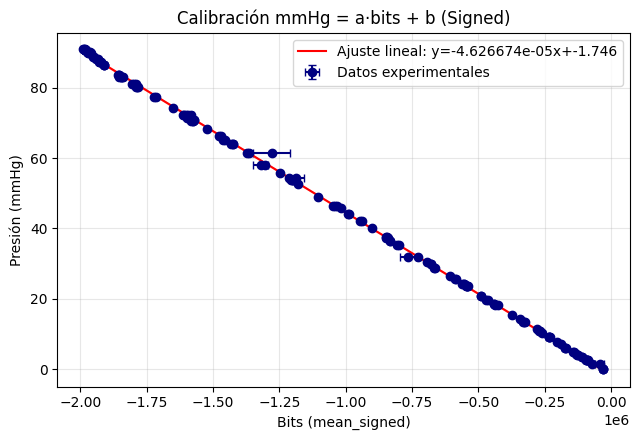

,Parámetro,Valor
0,Pendiente a,-4.626674e-05
1,Intercepto b,-1.746143e+00
2,σ(a),6.566635e-08
3,σ(b),8.367961e-02
4,R²,9.996838e-01
5,N,1.590000e+02



Ecuación del ajuste (Signed):
mmHg = (-4.626674e-05 ± 6.566635e-08)·bits + (-1.746 ± 0.084)
R² = 0.999684


In [ ]:
# ===== Calibración mmHg vs mean_signed (con incertidumbre 95%) =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# Assuming seg_stats DataFrame is available from previous cells
# If not, you might need to load it:
try:
    seg_stats = pd.read_csv("Pre_segments_stats.csv")
except FileNotFoundError:
     raise FileNotFoundError("Segment statistics file not found at /content/Pre_segments.csv. Please run the previous cell to generate it.")


# Explicitly convert relevant columns to numeric after loading and then to float64
for col in ["mmHg", "mean_signed", "std_signed", "dP_mmHg"]:
    if col in seg_stats.columns:
        seg_stats[col] = pd.to_numeric(seg_stats[col], errors="coerce").astype(np.float64)


# Drop rows with NA in relevant columns before filtering
seg_stats_filtered_s = seg_stats.dropna(subset=["mmHg", "mean_signed", "std_signed", "dP_mmHg"]).copy()


# Use only segments with finite mmHg & mean_signed using pd.isna()
fit_df_s = seg_stats_filtered_s[~pd.isna(seg_stats_filtered_s["mmHg"]) & ~pd.isna(seg_stats_filtered_s["mean_signed"])].copy()

# Define variables for signed fit
x_s = fit_df_s["mean_signed"].values
y_s = fit_df_s["mmHg"].values
xerr_s = fit_df_s["std_signed"].values
yerr_s = fit_df_s["dP_mmHg"].values

# === 3. Ajuste lineal con incertidumbre ===
coef_s, cov_s = np.polyfit(x_s, y_s, 1, cov=True)
a_s, b_s = coef_s
sa_s, sb_s = np.sqrt(np.diag(cov_s))

# Predicciones
x_line_s = np.linspace(np.nanmin(x_s), np.nanmax(x_s), 300)
y_fit_s = a_s*x_line_s + b_s

# Intervalo de confianza 95%
n_s = len(x_s)
alpha = 0.05
t_val_s = stats.t.ppf(1 - alpha/2, n_s-2)
# Calculate s_yx for the signed fit
s_yx_s = np.sqrt(np.sum((y_s - (a_s*x_s + b_s))**2) / (n_s-2))
x_mean_s = np.mean(x_s)
conf_s = t_val_s * s_yx_s * np.sqrt(1/n_s + (x_line_s - x_mean_s)**2 / np.sum((x_s - x_mean_s)**2))
y_upper_s = y_fit_s + conf_s
y_lower_s = y_fit_s - conf_s


# === 4. Gráfico ===
plt.figure(figsize=(6.5,4.5))
plt.errorbar(x_s, y_s, xerr=xerr_s, yerr=yerr_s, fmt='o', capsize=3, color='navy', label="Datos experimentales")
plt.plot(x_line_s, y_fit_s, 'r-', label=f"Ajuste lineal: y={a_s:.6e}x+{b_s:.3f}")
plt.fill_between(x_line_s, y_lower_s, y_upper_s, color='red', alpha=0.2, label="")
plt.xlabel("Bits (mean_signed)")
plt.ylabel("Presión (mmHg)")
plt.title("Calibración mmHg = a·bits + b (Signed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fit_mmHg_vs_mean_signed_95CI.png", dpi=300)
plt.show()

# === 5. Resumen analítico ===
r2_s = 1 - ((y_s - (a_s*x_s+b_s))**2).sum()/((y_s - y_s.mean())**2).sum()
summary_s = pd.DataFrame({
    "Parámetro":["Pendiente a","Intercepto b","σ(a)","σ(b)","R²","N"],
    "Valor":[a_s,b_s,sa_s,sb_s,r2_s,len(x_s)]
})
display(summary_s)
print("\nEcuación del ajuste (Signed):")
print(f"mmHg = ({a_s:.6e} ± {sa_s:.6e})·bits + ({b_s:.3f} ± {sb_s:.3f})")
print(f"R² = {r2_s:.6f}")

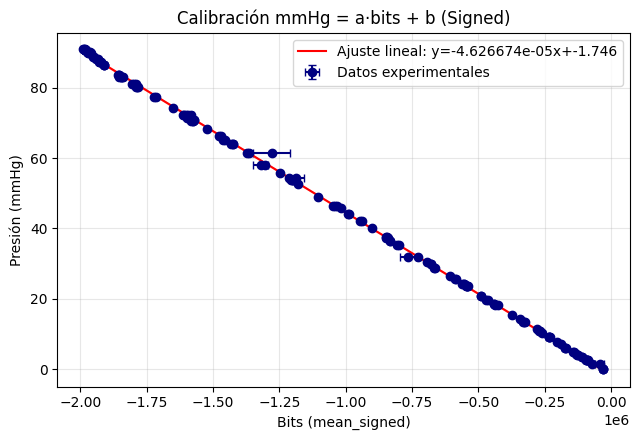

,Parámetro,Valor
0,Pendiente a,-4.626674e-05
1,Intercepto b,-1.746143e+00
2,σ(a),6.566635e-08
3,σ(b),8.367961e-02
4,R²,9.996838e-01
5,N,1.590000e+02



Ecuación del ajuste (Signed):
mmHg = (-4.626674e-05 ± 6.566635e-08)·bits + (-1.746 ± 0.084)
R² = 0.999684
Figura guardada en: fit_mmHg_vs_mean_signed_95CI.png


In [ ]:
# ===== Calibración mmHg vs mean_signed (con incertidumbre 95%) =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

# === 1. Cargar datos ===
# Debe (idealmente) contener: mean_signed, std_signed, mmHg, dP_mmHg
fname = "Pre_segments_stats.csv"   # cambia si tu archivo tiene otro nombre
df = pd.read_csv(fname)

# Coerce numéricos (si alguna falta, no truena)
needed_cols = ["mean_signed", "std_signed", "mmHg", "dP_mmHg"]
for c in needed_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Filtrar filas válidas para el ajuste (requiere mmHg y mean_signed)
fit_df = df.dropna(subset=["mmHg", "mean_signed"]).copy()

if len(fit_df) < 3:
    raise ValueError(
        f"Se requieren ≥3 puntos para ajustar con IC. Solo hay {len(fit_df)} "
        "filas válidas con 'mmHg' y 'mean_signed'."
    )

# === 2. Definir variables ===
x = fit_df["mean_signed"].values.astype(float)
y = fit_df["mmHg"].values.astype(float)

# xerr opcional si existe std_signed (si no, None)
xerr = fit_df["std_signed"].values.astype(float) if "std_signed" in fit_df else None

# yerr: usa dP_mmHg si existe; si no, un valor por defecto (igual criterio que tu script unsigned)
# (0.05*0.7356 es el ejemplo de incertidumbre mínima usada en el otro script)
if "dP_mmHg" in fit_df:
    yerr = fit_df["dP_mmHg"].values.astype(float)
else:
    yerr = np.full_like(y, 0.05*0.7356, dtype=float)

# === 3. Ajuste lineal con incertidumbre (polyfit + covarianza) ===
coef, cov = np.polyfit(x, y, 1, cov=True)
a, b = coef
sa, sb = np.sqrt(np.diag(cov))

# Predicciones para la recta
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 300)
y_fit = a*x_line + b

# Intervalo de confianza del ajuste (95%) para la media de la predicción
n = len(x)
alpha = 0.05
if n < 3:
    raise ValueError("Se requieren al menos 3 puntos para calcular el IC (n-2 en denominador).")

t_val = stats.t.ppf(1 - alpha/2, n-2)

# Error estándar de la regresión (residuos)
s_yx = np.sqrt(np.sum((y - (a*x + b))**2) / (n-2))

# Términos para IC de la media predicha
x_mean = np.mean(x)
Sxx = np.sum((x - x_mean)**2)
conf = t_val * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / Sxx)

y_upper = y_fit + conf
y_lower = y_fit - conf

# === 4. Gráfico ===
plt.figure(figsize=(6.5,4.5))

# Dispersión con barras de error si están disponibles
plt.errorbar(
    x, y,
    xerr=xerr,
    yerr=yerr,
    fmt='o',
    capsize=3,
    color='navy',
    label="Datos experimentales"
)

# Recta de ajuste + banda de IC
plt.plot(x_line, y_fit, 'r-', label=f"Ajuste lineal: y={a:.6e}x+{b:.3f}")
plt.fill_between(x_line, y_lower, y_upper, color='red', alpha=0.2)

plt.xlabel("Bits (mean_signed)")
plt.ylabel("Presión (mmHg)")
plt.title("Calibración mmHg = a·bits + b (Signed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fit_mmHg_vs_mean_signed_95CI.png", dpi=300)
plt.show()

# === 5. Resumen analítico ===
# R² clásico
ss_res = np.sum((y - (a*x + b))**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot

summary = pd.DataFrame({
    "Parámetro": ["Pendiente a", "Intercepto b", "σ(a)", "σ(b)", "R²", "N"],
    "Valor":     [a,            b,             sa,    sb,    r2,   n]
})
display(summary)

print("\nEcuación del ajuste (Signed):")
print(f"mmHg = ({a:.6e} ± {sa:.6e})·bits + ({b:.3f} ± {sb:.3f})")
print(f"R² = {r2:.6f}")
print("Figura guardada en: fit_mmHg_vs_mean_signed_95CI.png")
